In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pickle

pkl_path =  '/mnt/data/adat01/adv_OpenPCDet/output/cfgs/kitti_models/pv_rcnn/tsne_pretrain_pvrcnn/tsne_scores_14042024_masked.pkl'

# Load data from pickle file
with open(pkl_path, 'rb') as f:
    pretrained_data = pickle.load(f)


In [3]:
pretrained_data.keys()

dict_keys(['iou_roi_pl', 'iou_roi_gt', 'obj_scores', 'gt_boxes', 'roi_scores', 'num_points_in_roi', 'class_labels', 'iteration', 'shared_features', 'frame_id', 'shared_features_gt'])

New branch (tsne_pretrain_3diou_org) to capture and recreate tSNE plots for pretrained data
Script used to generate ckpt for TsNE listed below:

In [ ]:

# {
# 	"version": "0.2.0",
# 	"configurations": [
#     	{
#         	"name": "Run with argument",
#         	"type": "python",
#         	"request": "launch",
#         	"program": "${file}",
#         	"console": "integratedTerminal",
#         	"cwd": "${workspaceFolder}/tools",
#         	"env": {"CUDA_VISIBLE_DEVICES": "1"},
#         	"args": ["--cfg_file" ,
# 					"./cfgs/kitti_models/pv_rcnn.yaml",
#                 	"--split",
#                 	"train_0.01_1",
#                 	"--batch_size",
#                 	"8",
#                 	"--ckpt_save_interval",
#                 	"1",
#                 	"--repeat",
# 					"1",
# 					"--epochs",
# 					"81",
#                 	"--fix_random_seed",
#                 	"--extra_tag",
#                 	"tsne_pretrain_pvrcnn", 
# 					"--ckpt",
# 					"/mnt/data/OpenPCDet_soft-teacher/output/old/cfgs/kitti_models/pv_rcnn/split_0.01_1/ckpt/checkpoint_epoch_80.pth"
#         	],
#     	}
# 	]
# }

In [7]:
len(pretrained_data['roi_scores'])

4736

In [8]:
shared_features_list = pretrained_data['shared_features']
# Shared_features_list contains data for ROIs
unsqueezed_tensors = [tensor.unsqueeze(0) for tensor in shared_features_list]
ft_sh = torch.cat(unsqueezed_tensors, dim=0)
ft_sh = ft_sh.squeeze()
print(ft_sh.shape) 
roi_classes =  torch.tensor(pretrained_data['class_labels'])
print(roi_classes.shape)

torch.Size([4736, 256])
torch.Size([4736])


In [10]:
shared_features_gt_list = pretrained_data['shared_features_gt']
# Shared_features_list contains data for ROIs
unsqueezed_tensors = [tensor.unsqueeze(0) for tensor in shared_features_gt_list]
ft_sh_gt = torch.cat(unsqueezed_tensors, dim=0)
print(ft_sh_gt.shape) 
gt_classes =  torch.tensor(pretrained_data['gt_boxes'])
print(gt_classes.shape)

torch.Size([1028, 256])
torch.Size([1028, 8])


In [24]:
selected_sh = ft_sh
selected_roi_classes = roi_classes -1 

/mnt/data/anaconda3/envs/adat_pcdetv5/lib/python3.9/site-packages/matplotlib/collections.py:1100: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


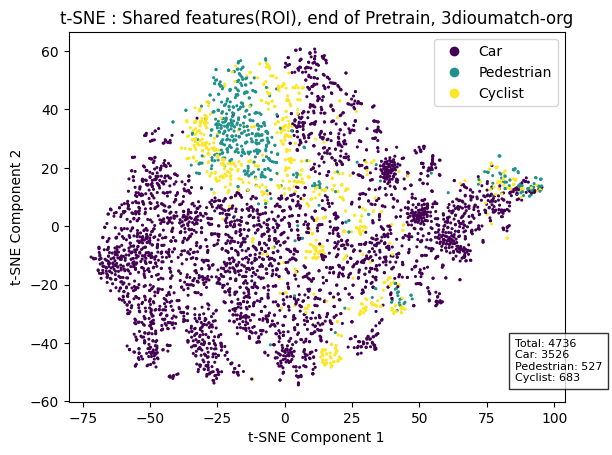

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = selected_sh.cpu().numpy()
y = selected_roi_classes.cpu().numpy().astype(int)

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1000, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap='viridis', s=1.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE : Shared features(ROI), end of Pretrain, 3dioumatch-org')

# Add legend
class_names = ['Car', 'Pedestrian', 'Cyclist']
handles, _ = scatter.legend_elements(num=np.unique(y))
legend = plt.legend(handles, class_names, loc='upper right')

# Add a box showing occurrences of each class
class_counts = np.bincount(y)
total_count = np.sum(class_counts)
class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count}" for class_name, count in zip(class_names, class_counts)]
occurrences_text = '\n'.join(class_counts_str)
plt.text(0.9, 0.05, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

plt.show()


In [26]:
selected_sh_gt = ft_sh_gt
selected_gt_classes = gt_classes[:,-1]

/mnt/data/anaconda3/envs/adat_pcdetv5/lib/python3.9/site-packages/matplotlib/collections.py:1100: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


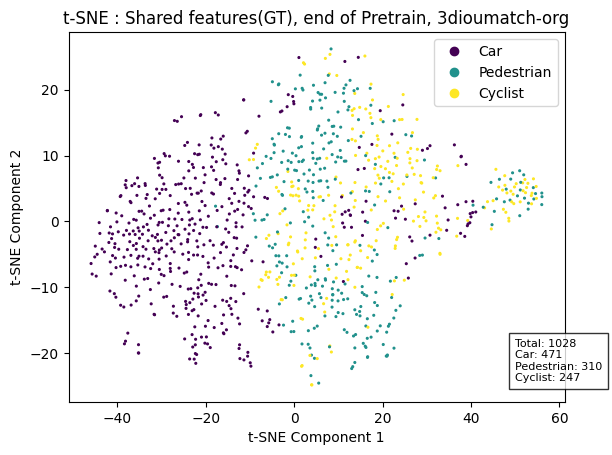

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = selected_sh_gt.cpu().numpy()
y = selected_gt_classes.cpu().numpy().astype(int)

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1000, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap='viridis', s=1.5)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE : Shared features(GT), end of Pretrain, 3dioumatch-org')

# Add legend
class_names = ['Car', 'Pedestrian', 'Cyclist']
handles, _ = scatter.legend_elements(num=np.unique(y))
legend = plt.legend(handles, class_names, loc='upper right')

# Add a box showing occurrences of each class
class_counts = np.bincount(y)
total_count = np.sum(class_counts)
class_counts_str =  [f"Total: {total_count}"] + [f"{class_name}: {count}" for class_name, count in zip(class_names, class_counts)]
occurrences_text = '\n'.join(class_counts_str)
plt.text(0.9, 0.05, occurrences_text, transform=plt.gca().transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

plt.show()
